1.0 DATA PREPROCESSING

In [ ]:
!pip install pgmpy
import pandas as pd
import numpy as np
import random
from pgmpy.models import BayesianModel
from pgmpy.estimators import *
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
# Data of top 50 songs 
X = np.loadtxt('top50.txt', delimiter=',',dtype=str)

  
# Convert in dataframe
df = pd.DataFrame(X, columns=["Position","Track.Name","Artist.Name","Genre",
                              "BPM","Energy","Danceability","Loudness",
                              "Liveness","Valence.","Length","Acousticness..",
                              "Speechiness.","Popularity"]) 
# drop
df = df.drop(['Track.Name'],axis=1)
df = df.drop(['Artist.Name'],axis=1)
df = df.drop(['Danceability'],axis=1)
df = df.drop(['Liveness'],axis=1)
df = df.drop(['Valence.'],axis=1)
df = df.drop(['Acousticness..'],axis=1)
df = df.drop(['Speechiness.'],axis=1)


df_gen = pd.read_csv('data.csv')

for i in range(1,21):
  df_gen = df_gen.drop(['mfcc{}'.format(i)],axis=1)

df_gen = df_gen.drop(['tempo'],axis=1)
df_gen = df_gen.drop(['beats'],axis=1)
df_gen = df_gen.drop(['chroma_stft'],axis=1)
df_gen = df_gen.drop(['rmse'],axis=1)
df_gen = df_gen.drop(['spectral_centroid'],axis=1)
df_gen = df_gen.drop(['rolloff'],axis=1)
df_gen = df_gen.drop(['zero_crossing_rate'],axis=1)
df_gen = df_gen.drop(['filename'],axis=1)

df = df.dropna()
df_gen = df_gen.dropna()
df = df.replace({'"':''}, regex=True)

In [ ]:
df_gen.head()
df_gen = df_gen[~df_gen['label'].astype('str').str.contains('classical')] 
df_gen = df_gen[~df_gen['label'].astype('str').str.contains('country')] 
df_gen = df_gen[~df_gen['label'].astype('str').str.contains('disco')]
df_gen['label'].unique()

array(['room', 'hiphop', 'rap', 'pop', 'reggaeton'], dtype=object)

In [ ]:
# Compact Genres in macrocategories
for i in range(0,50):
  if 'pop' in df['Genre'][i] or 'brostep' in df['Genre'][i]:
    df['Genre'][i]='pop'
  elif 'rap' in df['Genre'][i] or 'trap' in df['Genre'][i]:
    df['Genre'][i]='rap'
  elif 'edm' in df['Genre'][i] or 'room' in df['Genre'][i]:
    df['Genre'][i]='room'
  elif 'latin' in df['Genre'][i] or 'r&b en espanol' in df['Genre'][i] or 'reggaeton flow' in df['Genre'][i]:
    df['Genre'][i]='reggaeton'
  elif 'hip hop' in df['Genre'][i] or 'boy band' in df['Genre'][i]:
    df['Genre'][i]='hip hop'

In [ ]:
def mean_gen(label_str):
  count, counter = 0,0
  for i in range(0,df_gen.shape[0]-1):
    if df_gen['label'].iloc[i] == label_str:
      count = count + 1
      counter = counter + df_gen['spectral_bandwidth'].iloc[i]
  mean = counter / count
  return mean

mean_room = mean_gen('room')
mean_pop = mean_gen('pop')
mean_hh = mean_gen('hiphop')
mean_rap = mean_gen('rap')
mean_reggaeton = mean_gen('reggaeton')

In [ ]:
df['band_width'] = pd.Series(np.random.randn(len(df['Genre'])), index=df.index)

In [ ]:
for i in range(0,50):
  if df['Genre'].iloc[i] == 'room':
    df['band_width'][i] = mean_room + random.randrange(-300, 300, 1)
  if df['Genre'].iloc[i] == 'pop':
    df['band_width'][i] = mean_pop + random.randrange(-300, 300, 1)
  if df['Genre'].iloc[i] == 'hiphop':
    df['band_width'][i] = mean_hh + random.randrange(-300, 300, 1)
  if df['Genre'].iloc[i] == 'rap':
    df['band_width'][i] = mean_rap + random.randrange(-300, 300, 1)
  if df['Genre'].iloc[i] == 'reggaeton':
    df['band_width'][i] = mean_reggaeton + random.randrange(-300, 300, 1)

In [ ]:
# Set the bandwitdh 
for i in range(0,50):
  if df['band_width'].iloc[i] > 2400:
    df['band_width'][i] = 'high'
  else:
    df['band_width'][i] = 'low'

In [ ]:
# cast 
df['Position'] = pd.to_numeric(df['Position'])
df['BPM'] = pd.to_numeric(df['BPM'])
df['Energy'] = pd.to_numeric(df['Energy'])
df['Loudness'] = pd.to_numeric(df['Loudness'])
df['Length'] = pd.to_numeric(df['Length'])
df['Popularity'] = pd.to_numeric(df['Popularity'])

In [ ]:
bpm_mean = df['BPM'].mean()
energy_mean = df['Energy'].mean()
loud_mean = df['Loudness'].mean()
len_mean = df['Length'].mean()
pop_mean = df['Popularity'].mean()
pos_len = len(df['Position'])

In [ ]:
# Set values by a treshold
for i in range(0,50):

  if (df['BPM'][i] > bpm_mean):
    df['BPM'][i] = 'high'
  else:
    df['BPM'][i] = 'low'

  if (df['Energy'][i]>  energy_mean):
    df['Energy'][i] = 'high'
  else:
    df['Energy'][i] = 'low'

  if (df['Loudness'][i]>  loud_mean):
    df['Loudness'][i] = 'high'
  else:
    df['Loudness'][i] = 'low'

  if (df['Length'][i]> len_mean):
    df['Length'][i] = 'high'
  else:
    df['Length'][i] = 'low'

  if (df['Popularity'][i]> pop_mean):
    df['Popularity'][i] = 'high'
  else:
    df['Popularity'][i] = 'low'

  if (df['Position'][i]< pos_len/3 ):
    df['Position'][i] = 'high'
  elif (df['Position'][i]> 2* pos_len/3 ):
    df['Position'][i] = 'low'
  else:
    df['Position'][i] = 'medium'

In [ ]:
df.head(50)

,Position,Genre,BPM,Energy,Loudness,Length,Popularity,band_width
0,high,pop,low,low,low,low,low,high
1,high,reggaeton,low,high,high,high,high,low
2,high,pop,high,high,high,low,low,high
3,high,pop,low,high,low,low,low,high
4,high,rap,high,high,high,low,high,low
5,high,pop,low,high,high,high,low,high
6,high,rap,high,low,low,low,high,low
7,high,pop,low,high,high,high,high,high
8,high,rap,high,low,low,low,low,low
9,high,pop,high,low,low,low,high,high


1.1 Now we have a cleaned and usable Dataset

2.0 Bayesian Network Creation

In [ ]:
# Create the Bayesian Model
model = BayesianModel([('band_width', 'Genre'),('BPM', 'Genre'),  
                       ('Genre', 'Position'),('Energy', 'Position'),
                       ('Loudness', 'Position'),('Length', 'Position'), 
                       ('Position', 'Popularity')])
b_est = BayesianEstimator(model, df)

def cdp_estimator(property):
  return b_est.estimate_cpd(property, prior_type='BDeu', equivalent_sample_size=50)

cpd_band = cdp_estimator('band_width')
cpd_bpm = cdp_estimator('BPM')
cpd_energy = cdp_estimator('Energy')
cpd_loud = cdp_estimator('Loudness')
cpd_length = cdp_estimator('Length')
cpd_genre = cdp_estimator('Genre')
cpd_pos = cdp_estimator('Position')
cpd_pop = cdp_estimator('Popularity')

#fitting the model in the bayesian net (add cpt's to the model)
model.fit(df, estimator=BayesianEstimator)
print('Validity of the model: ', model.check_model())

Validity of the model:  True


In [ ]:
print(cpd_energy)
print(cpd_band)
print(cpd_bpm)

+--------------+------+
| Energy(high) | 0.54 |
+--------------+------+
| Energy(low)  | 0.46 |
+--------------+------+
+------------------+------+
| band_width(high) | 0.53 |
+------------------+------+
| band_width(low)  | 0.47 |
+------------------+------+
+-----------+------+
| BPM(high) | 0.46 |
+-----------+------+
| BPM(low)  | 0.54 |
+-----------+------+


2.1 Draw The network

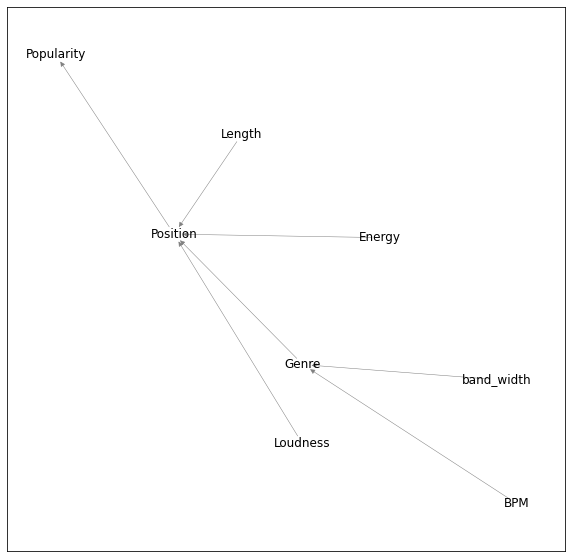

In [ ]:
nodes = list(model.nodes())
edges = list(model.edges())

DAG = nx.DiGraph()
DAG.add_edges_from(edges)
fig = plt.figure(figsize = (10,10))
pos = nx.spring_layout(DAG) #Position nodes computed by using Fruchterman-Reingold force-directed algorithm.
nx.draw_networkx_nodes(DAG, pos=pos, node_color='white', node_size=20)
nx.draw_networkx_labels(DAG, pos=pos)
nx.draw_networkx_edges(DAG, pos=pos, edge_color='gray', width = 0.5, arrows=True)
plt.show()

2.2 Queries

In [ ]:
exact_inference = VariableElimination(model)

In [ ]:
print('\n \nThe CPT of Position given genre room: ')
query1_pos = exact_inference.query(['Position'],{'Genre':'room'})
print(query1_pos)

Eliminating: Popularity: 100%|██████████| 6/6 [00:00<00:00, 294.65it/s]


 
The CPT of Position given genre room: 
+------------------+-----------------+
| Position         |   phi(Position) |
+==================+=================+
| Position(high)   |          0.1830 |
+------------------+-----------------+
| Position(low)    |          0.4442 |
+------------------+-----------------+
| Position(medium) |          0.3729 |
+------------------+-----------------+


In [ ]:
query2_pos = exact_inference.query(['Position'],{'BPM':'high','Loudness':'low','Genre':'rap'})
print('\n \nThe CPT of Position given high BPM, low Loudness and rap Genre: ')
print(query2_pos)

Eliminating: Popularity: 100%|██████████| 4/4 [00:00<00:00, 197.26it/s]


 
The CPT of Position given high BPM, low Loudness and rap Genre: 
+------------------+-----------------+
| Position         |   phi(Position) |
+==================+=================+
| Position(high)   |          0.3716 |
+------------------+-----------------+
| Position(low)    |          0.2567 |
+------------------+-----------------+
| Position(medium) |          0.3716 |
+------------------+-----------------+


In [ ]:
print('\n \nThe CPT of Genre given high BPM and low band_windth: ')
query1_gen = exact_inference.query(['Genre'],{'BPM':'high','band_width':'low'})
print(query1_gen)

Eliminating: Length:   0%|          | 0/5 [00:00<?, ?it/s]


 
The CPT of Genre given high BPM and low band_windth: 


Eliminating: Popularity: 100%|██████████| 5/5 [00:00<00:00, 167.37it/s]

+------------------+--------------+
| Genre            |   phi(Genre) |
+==================+==============+
| Genre(hip hop)   |       0.2195 |
+------------------+--------------+
| Genre(pop)       |       0.0244 |
+------------------+--------------+
| Genre(rap)       |       0.4146 |
+------------------+--------------+
| Genre(reggaeton) |       0.2195 |
+------------------+--------------+
| Genre(room)      |       0.1220 |
+------------------+--------------+


In [ ]:
print('\n \nThe CPT of Genre given high BPM and low band_windth: ')
query1_gen = exact_inference.query(['Genre'],{'BPM':'high','band_width':'high'})
print(query1_gen)

Eliminating: Popularity: 100%|██████████| 5/5 [00:00<00:00, 206.25it/s]


 
The CPT of Genre given high BPM and low band_windth: 
+------------------+--------------+
| Genre            |   phi(Genre) |
+==================+==============+
| Genre(hip hop)   |       0.0189 |
+------------------+--------------+
| Genre(pop)       |       0.8491 |
+------------------+--------------+
| Genre(rap)       |       0.0189 |
+------------------+--------------+
| Genre(reggaeton) |       0.0943 |
+------------------+--------------+
| Genre(room)      |       0.0189 |
+------------------+--------------+


2.3 Check Indipendencies

In [ ]:
print('\n \nThe CPT of Popularity given high Position and pop Genre: ')
query4 = exact_inference.query(['Popularity'],{'Position':'medium','Genre':'pop'})
print(query4)
print('\n \nThe CPT of Popularity given only high Position: ')
query5 = exact_inference.query(['Popularity'],{'Position':'medium'})
print(query5)
print('\n \nIndipendency btw Popularity and Genre is checked because CPTs are equal. ')


Eliminating: Loudness: 100%|██████████| 6/6 [00:00<00:00, 203.42it/s]


 
The CPT of Popularity given high Position and pop Genre: 
+------------------+-------------------+
| Popularity       |   phi(Popularity) |
+==================+===================+
| Popularity(high) |            0.7411 |
+------------------+-------------------+
| Popularity(low)  |            0.2589 |
+------------------+-------------------+

 
The CPT of Popularity given only high Position: 
+------------------+-------------------+
| Popularity       |   phi(Popularity) |
+==================+===================+
| Popularity(high) |            0.7411 |
+------------------+-------------------+
| Popularity(low)  |            0.2589 |
+------------------+-------------------+

 
Indipendency btw Popularity and Genre is checked because CPTs are equal. 
